# Bulk sequencing mapping

Notebook containing pipeline for calling mutations in lambda-sorted highly defective populations. Data graphed here as well.

Taking a bit of an unusual step that, specifically for NS1, we will keep any and all deletion junctions noted in our BLAST database (for others this is not done).

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline
scripts = 'Scripts'
import seaborn as sns
import glob

sys.path.append(scripts)
import fastQHandling
import BLASTanalysis
import DeletionAnalysis
import scipy
import numpy as np
import math

from scipy import stats
from statsmodels.stats import multitest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from IPython.display import IFrame    
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

#Superdirectory containing fastq files for all experiments
sequenceDirectory = "Sequencing/lambdaBulkSort"
#links to precompiled STAR indices
genome = 'Database/WSN_star'
#fasta file for influenza genome
WSNfasta = 'Database/WSN_vRNA.fa'
#precompiled blast database for WSN_vRNA
WSNblastdb = 'Database/WSN_BLAST/WSN_vRNA'
#list of pcr adapters for trimming
adapterFile = 'Database/adapter.fa'

#Results
resultsDir = 'Results'
if not os.path.isdir(resultsDir):
    os.mkdir(resultsDir)
#blast variables for identifying junctions
percentIdentity = 90
wordSize = 10
gapOpen = 5
gapExtend = 2
eValue = 0.000001
outFormat = '"6 qseqid qlen qstart qend sstart send evalue sseqid qseq"'


#multiprocessing for mapping to speed things up a bit
from multiprocessing import Pool
numProcessors = 4
import subprocess
#some parameters for plotting

figureDirectory = 'Figures/'
if not os.path.isdir(figureDirectory):
    os.mkdir(figureDirectory)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 16, 'axes.titlesize':'medium',})
sns.set_style("white")
sns.set_style("ticks")
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

colormap = 'colorblind'
colors = sns.color_palette(colormap, 8)
segments = ['PB1_vRNA','HA_vRNA','PB2_vRNA',  'PA_vRNA','NP_vRNA','NA_vRNA','M_vRNA','NS_vRNA']
fluColors = {}
for color, segment in enumerate(segments):
    fluColors[segment] = colors[color]
segments = ['PB2_vRNA', 'PB1_vRNA', 'PA_vRNA','HA_vRNA','NP_vRNA','NA_vRNA','M_vRNA','NS_vRNA']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})

## Mapping

Similar to the pipeline used in Mendes and Russell 2022, with only a slight modification to use less stringent calls for NS segment.

In [3]:
experiments = []
for file in glob.glob(sequenceDirectory + '/*.fastq*'):
    fileName = file.split('/')[-1]
    descriptors = fileName.split('_')
    biologicalReplicate = descriptors[0]
    technicalReplicate = descriptors[1]
    interferonState = descriptors[2]
    read = descriptors[-2]
    #for this paper, currently only 1 run per experiment, but might as well add some flexibility.
    sequencingRun = '_'.join(descriptors[3:5])
    experiments += [pd.DataFrame({'biological_replicate':[biologicalReplicate],
                                 'technical_replicate':[technicalReplicate], 'experimental_condition':[interferonState],
                                  'read_pair':[read], 
                                  'file_name':[file], 'sequencing_run':[sequencingRun]})]
experiments = pd.concat(experiments).reset_index().drop(columns=['index'])
unique = experiments.groupby([ 'biological_replicate', 'technical_replicate', 'experimental_condition']).file_name.apply(list).reset_index()
experiments.set_index(['biological_replicate','technical_replicate', 'experimental_condition'])

read_pair  \
biological_replicate technical_replicate experimental_condition             
1                    1                   negative                      R1   
                                         negative                      R2   
                                         positive                      R1   
                                         positive                      R2   
                     2                   negative                      R1   
                                         negative                      R2   
                                         positive                      R1   
                                         positive                      R2   
                     3                   negative                      R1   
                                         negative                      R2   
                                         positive                      R1   
                                         positive                      R2   
2                    1                   negative                      R1   
                                         negative                      R2   
                                         positive                      R1   
                                         positive                      R2   
                     2                   negative                      R1   
                                         negative                      R2   
                                         positive                      R1   
                                         positive                      R2   
                     3                   negative                      R1   
                                         negative                      R2   
                                         positive                      R1   
                                         positive                      R2   

                                                                                                         file_name  \
biological_replicate technical_replicate experimental_condition                                                      
1                    1                   negative                Sequencing/lambdaBulkSort/1_1_negative_S22_L00...   
                                         negative                Sequencing/lambdaBulkSort/1_1_negative_S22_L00...   
                                         positive                Sequencing/lambdaBulkSort/1_1_positive_S21_L00...   
                                         positive                Sequencing/lambdaBulkSort/1_1_positive_S21_L00...   
                     2                   negative                Sequencing/lambdaBulkSort/1_2_negative_S24_L00...   
                                         negative                Sequencing/lambdaBulkSort/1_2_negative_S24_L00...   
                                         positive                Sequencing/lambdaBulkSort/1_2_positive_S23_L00...   
                                         positive                Sequencing/lambdaBulkSort/1_2_positive_S23_L00...   
                     3                   negative                Sequencing/lambdaBulkSort/1_3_negative_S26_L00...   
                                         negative                Sequencing/lambdaBulkSort/1_3_negative_S26_L00...   
                                         positive                Sequencing/lambdaBulkSort/1_3_positive_S25_L00...   
                                         positive                Sequencing/lambdaBulkSort/1_3_positive_S25_L00...   
2                    1                   negative                Sequencing/lambdaBulkSort/2_1_negative_S28_L00...   
                                         negative                Sequencing/lambdaBulkSort/2_1_negative_S28_L00...   
                                         positive                Sequencing/lambdaBulkSort/2_1_positive_S27_L00...   
                                         positive      

Quality metrics on sequencing run.

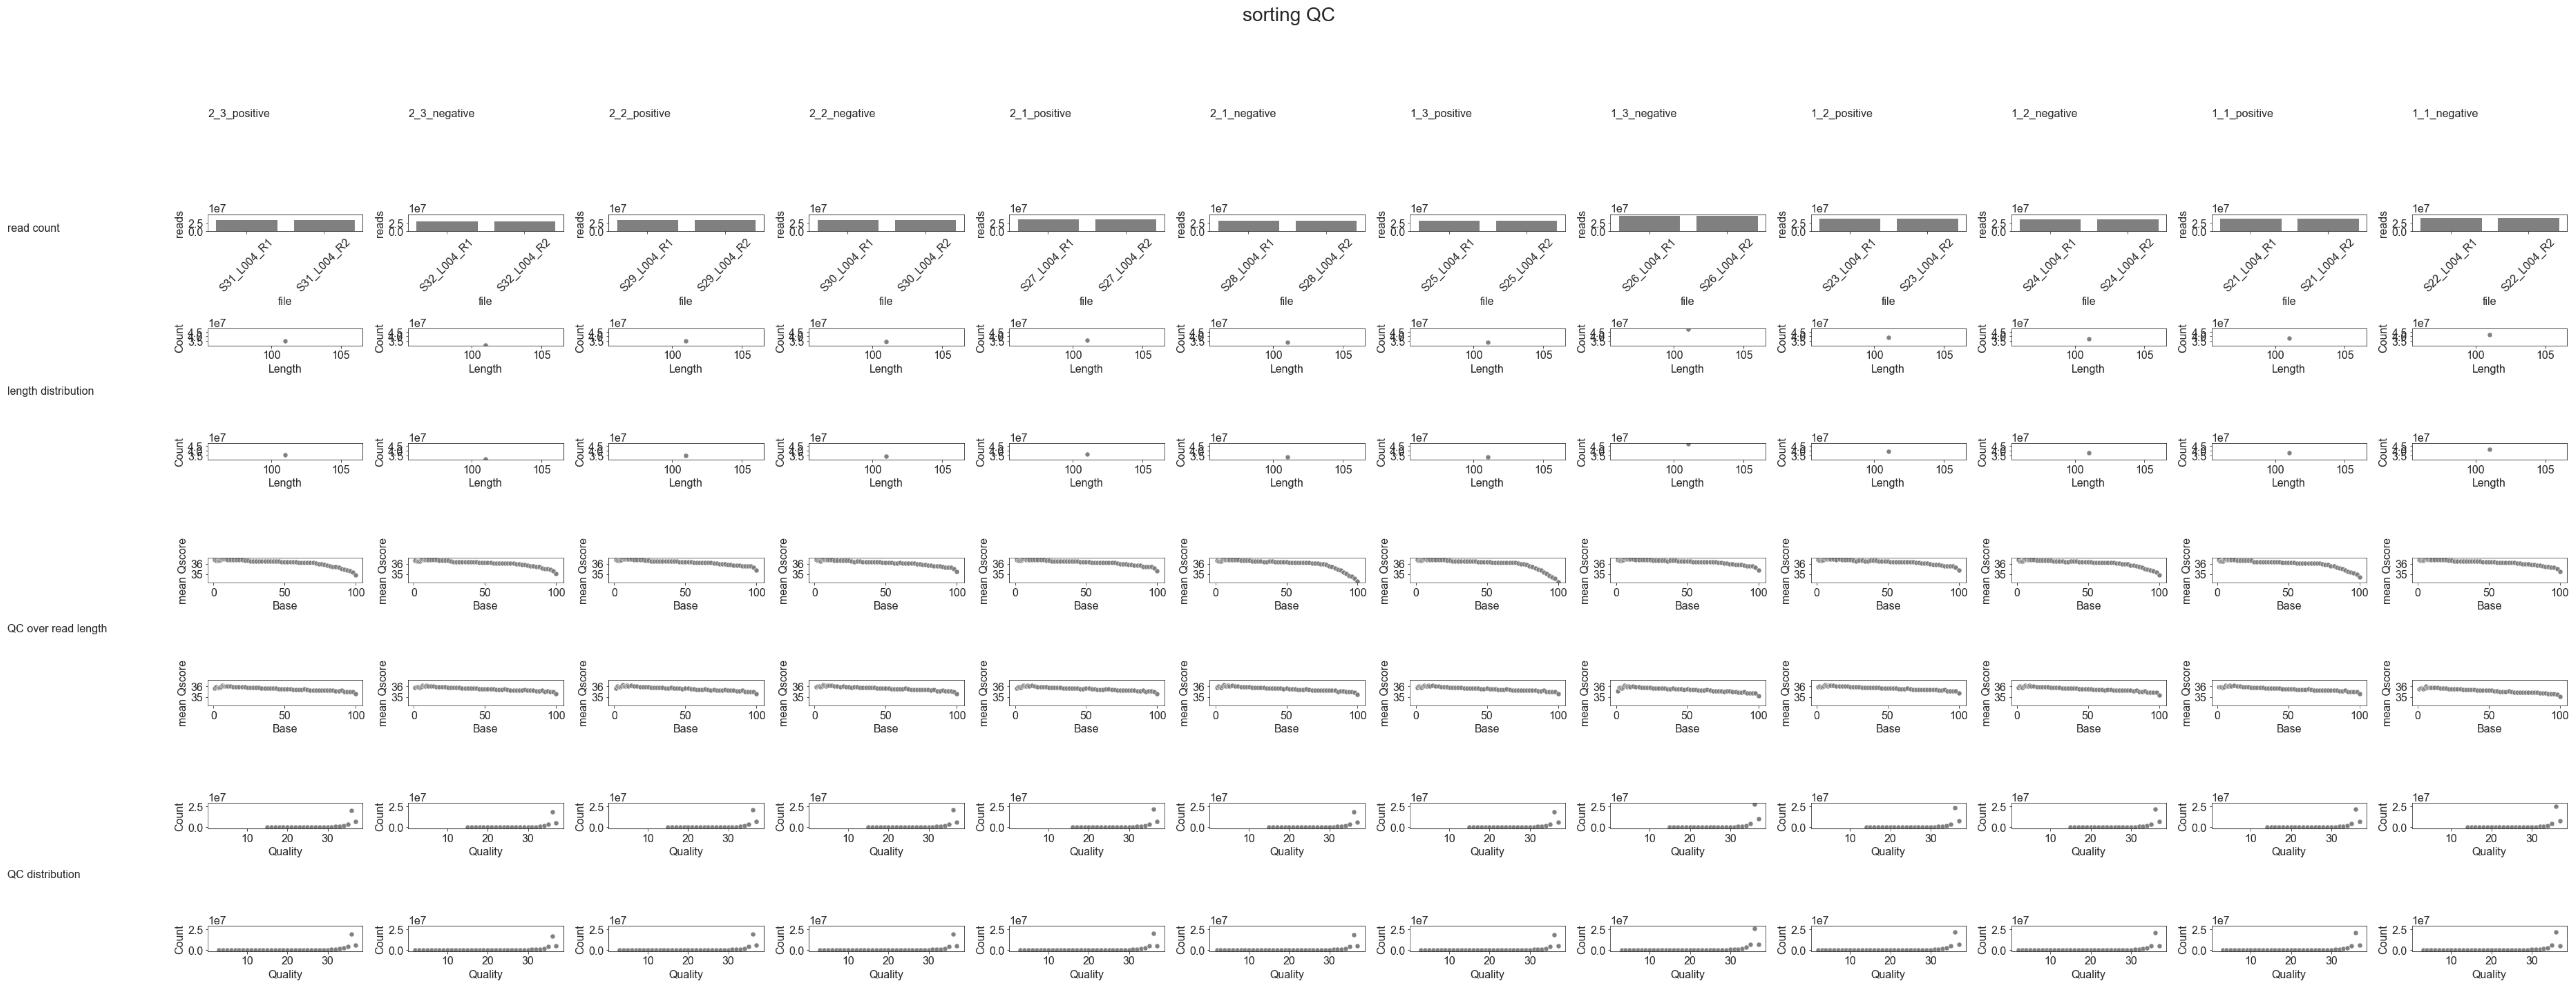

In [23]:
def fastQC(tupleArgument):
    sampleName = tupleArgument[0]
    reads = tupleArgument[1]
    return {sampleName:fastQHandling.fastQCreport(sampleName=sampleName, reads=reads)}
figsDisplay = []
reports = []
results = {}
samples = {}
for index, row in experiments.iterrows():
    sample = '_'.join([str(row.biological_replicate), str(row.technical_replicate), row.experimental_condition])
    read = row.file_name
    readName = row.sequencing_run + '_' + row.read_pair
    if sample not in samples.keys():
        samples[sample] = {readName:read}
    else:
        samples[sample][readName] = read
popList = [(sample, samples[sample]) for sample in list(samples.keys())]
while len(popList) > 0:
    with Pool(processes = numProcessors) as p:
        reports += p.map(fastQC, [popList.pop() for i in range(numProcessors) if len(popList) != 0])
reports = {key:value for dictionary in reports for key, value in dictionary.items()} 
a = fastQHandling.graphAllTheThings(data=reports, title='sorting QC')
#pdf for publication
plt.savefig(sequenceDirectory + '/sequenceQC.pdf', format='pdf', bbox_inches = "tight")
#png for showing here
plt.savefig(sequenceDirectory + '/sequenceQC.png', format='png', bbox_inches = "tight")
plt.close()
figsDisplay += [sequenceDirectory + '/sequenceQC.png']
width = 128 * len(figsDisplay)
g = plt.figure(1, (width, 128))
spec = g.add_gridspec(ncols= len(figsDisplay),nrows=1)
for column, fig in enumerate(figsDisplay):
    ax = g.add_subplot(spec[0,column])
    img=mpimg.imread(fig)
    ax.imshow(img)
    ax.axis('off')

Processed with trimmomatic.

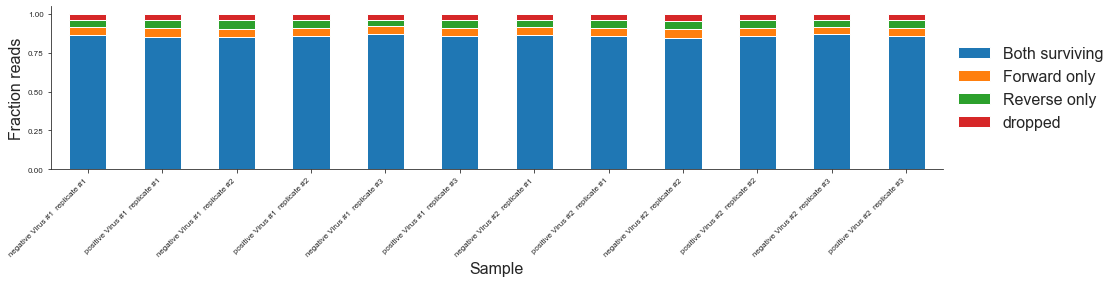

In [177]:
#list comprehension to get reports on trimming statistics. Using baseline recommendations of program creators.
#Can overwrite if need be. Does not rerun if already run in past, only grabs statistics. Pass rerun=True, if overwrite
#is desired.
if not os.path.isdir('/'.join([sequenceDirectory, 'trimmed_reads'])):
    os.mkdir('/'.join([sequenceDirectory, 'trimmed_reads']))
rows = experiments.groupby([ 'biological_replicate', 'technical_replicate', 'experimental_condition','sequencing_run']).file_name.apply(list).reset_index().iterrows()
stats = pd.concat([fastQHandling.trimCommandPaired(read1=row[1].file_name[0], 
                           read2= row[1].file_name[1],
                           outDirectory='/'.join([sequenceDirectory, 'trimmed_reads']),
                            adapterFile= adapterFile,
                            sampleName = ''.join([row[1].experimental_condition + ' Virus #',str(row[1].biological_replicate) + ' ',' replicate #', str(row[1].technical_replicate)]),
                          threads = numProcessors) for row in rows]).set_index('Sample')
#return raw numbers from above as they are generally more useful, but go ahead and collapse to percentages here
stats=stats.div(stats['Input read pairs'], axis=0).drop(columns=['Input read pairs'])
ax = stats.loc[:,['Both surviving', 'Forward only', 'Reverse only', 'dropped']].plot.bar(stacked=True,figsize=(16,3), fontsize=8)
sns.despine()
ax.legend( loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.xticks(rotation=45,horizontalalignment="right")
plt.ylabel('Fraction reads', fontsize=16)
plt.savefig(sequenceDirectory + '/trimming_statistics.pdf', format='pdf', bbox_inches = "tight")

Initial STAR mapping to identify contiguously mapping reads.

In [3]:

for index, row in experiments.groupby(['biological_replicate', 'technical_replicate', 'experimental_condition']).file_name.apply(list).reset_index().iterrows():
    #making sure pipeline supports multiple sequencing runs.
    condition = row.experimental_condition
    bio_replicate = row.biological_replicate
    tech_replicate = row.technical_replicate
    sequences = experiments[(experiments.biological_replicate == bio_replicate) & (experiments.technical_replicate == tech_replicate) & (
                            experiments.experimental_condition == condition)]
    outDirectory = resultsDir + '/STARalign'
    if not os.path.isdir(outDirectory):
        os.mkdir(outDirectory)
    #collate all R1s and associated R2s. ORDER CRITICAL, hence the whole song and dance here
    R1 = []
    R2 = []
    for index, row in sequences[sequences.read_pair == 'R1'].iterrows():
        read1 = row.file_name
        read2 = sequences[(sequences.sequencing_run == row.sequencing_run) & (
                sequences.read_pair == 'R2')].file_name.iloc[0]
        R1 += ['/'.join(read1.split('/')[:-1]) + '/trimmed_reads/' +read1.split('/')[-1]]
        R2 += ['/'.join(read2.split('/')[:-1]) + '/trimmed_reads/' +read2.split('/')[-1]]
    outprefix = outDirectory + '/' + 'Virus-' + str(bio_replicate) + '-' + str(tech_replicate) + '_' + condition + '_' 
    for read in R1 + R2:
        unzipped = read[:-3]
        !gunzip -c $read > $unzipped
    read1unzip = ','.join([read[:-3] for read in R1])
    read2unzip = ','.join([read[:-3] for read in R2])
    outprefix1 = outprefix + '_R1_'
    outprefix2 = outprefix + '_R2_'
    logFile1 =  outprefix1 + 'terminal.txt'
    logFile2 =  outprefix2 + 'terminal.txt'
    capture1 = !STAR --runMode alignReads --runThreadN $numProcessors --genomeDir $genome --readFilesIn $read1unzip --outFileNamePrefix $outprefix1 --outSAMtype BAM Unsorted   --alignSJoverhangMin 1000  --outFilterMismatchNmax 3 --scoreDelOpen -6 --scoreDelBase -6 --alignEndsType EndToEnd --outReadsUnmapped Fastx
    capture2 = !STAR --runMode alignReads --runThreadN $numProcessors --genomeDir $genome --readFilesIn $read2unzip --outFileNamePrefix $outprefix2 --outSAMtype BAM Unsorted   --alignSJoverhangMin 1000  --outFilterMismatchNmax 3 --scoreDelOpen -6 --scoreDelBase -6 --alignEndsType EndToEnd --outReadsUnmapped Fastx

    with open(logFile1, 'w') as outfile1, open(logFile2, 'w') as outfile2:
        for line in capture1:
            outfile1.write(line + '\n')
        for line in capture2:
            outfile2.write(line + '\n')

    for read in R1 + R2:
        unzipped = read[:-3]
        !rm -f $unzipped

Mapping metrics for first run.

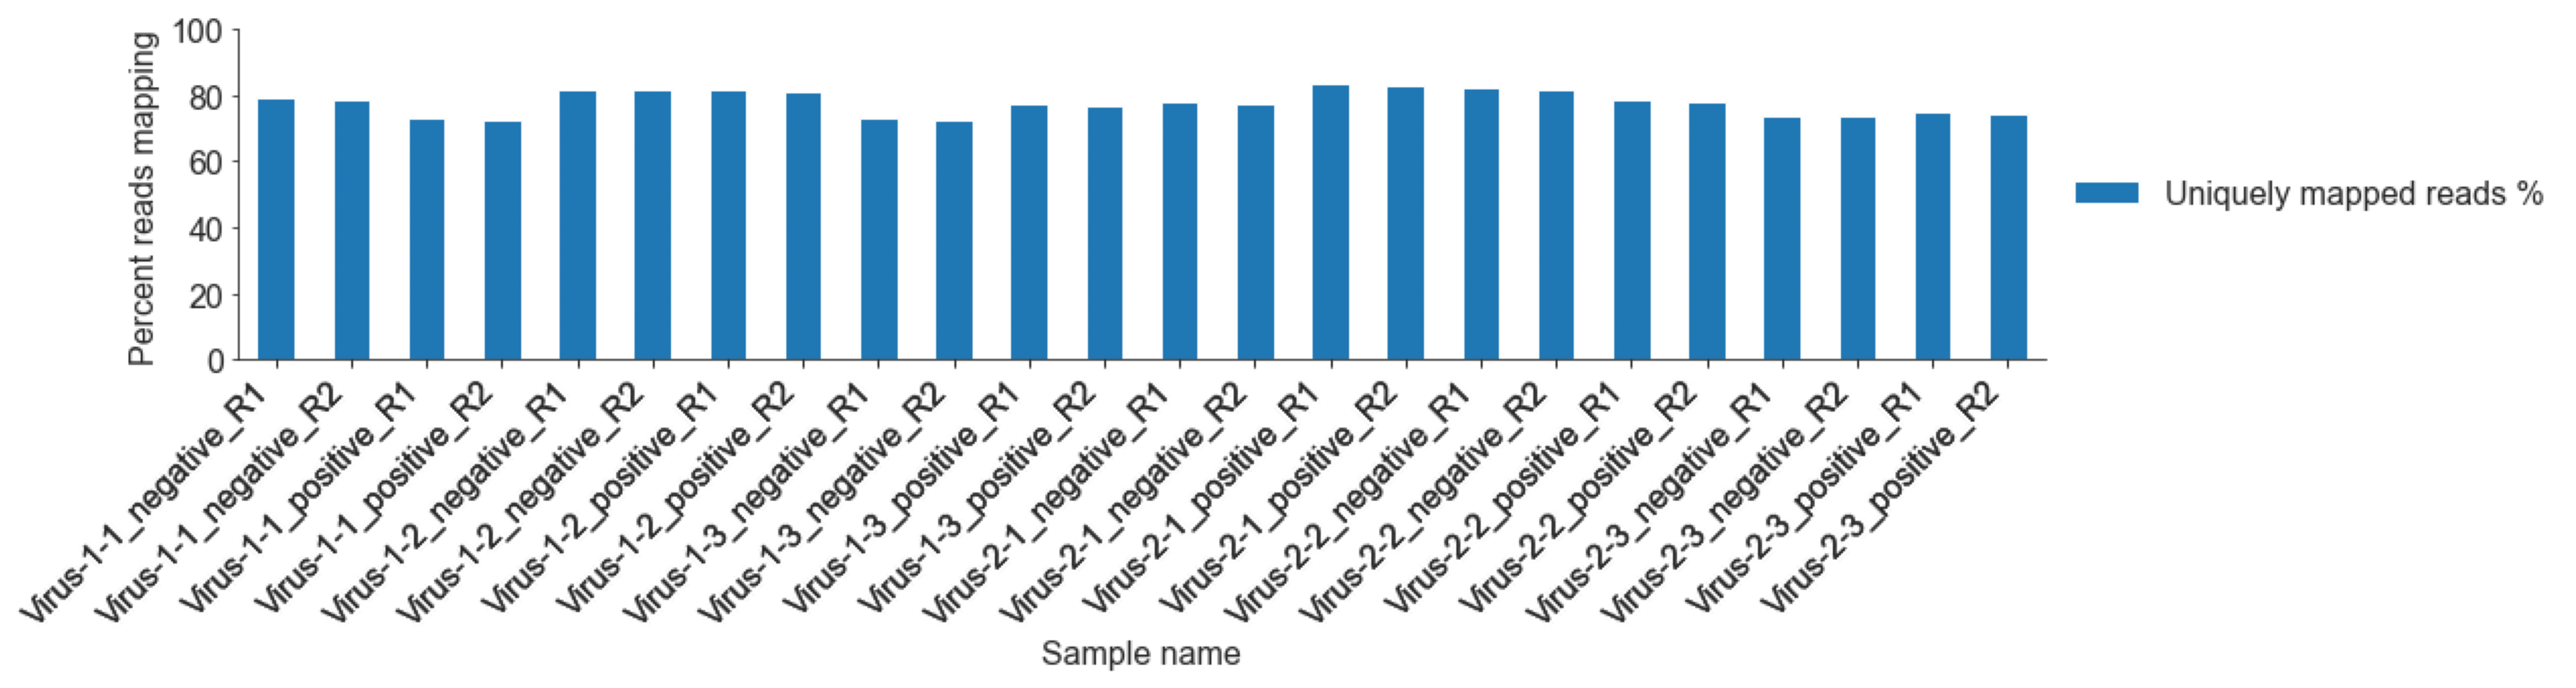

In [4]:
figsDisplay = []
reads = ['R1', 'R2']
data = []
for index, row in experiments.iterrows():
    for read in reads:
        sampleName = 'Virus-' + \
               str(row.biological_replicate) + '-' + \
               str(row.technical_replicate) + '_' + \
               row.experimental_condition 
        filename = resultsDir + '/STARalign/' + sampleName + '_'  + '_' + read + '_Log.final.out'
        sampleName = sampleName + '_' + read
        data += [fastQHandling.STARreport(filename,sampleName)]

data = pd.concat(data)
data.loc[:,['Uniquely mapped reads %','Sample name']].set_index('Sample name').plot.bar(stacked=True,figsize=(16,3), fontsize=16)
sns.despine()
plt.legend( loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.xticks(rotation=45,horizontalalignment="right")
plt.ylabel('Percent reads mapping', fontsize=16)
plt.ylim(0,100)
plt.savefig(resultsDir + '/STARalign/alignment.pdf', format='pdf', bbox_inches = "tight")
#png for showing here
plt.savefig(resultsDir + '/STARalign/alignment.png', format='png', bbox_inches = "tight")
plt.close()
figsDisplay += [resultsDir + '/STARalign/alignment.png']
width = 64 * len(figsDisplay)
g = plt.figure(1, (width, 32))
spec = g.add_gridspec(ncols= len(figsDisplay),nrows=1)
for column, fig in enumerate(figsDisplay):
    ax = g.add_subplot(spec[0,column])
    img=mpimg.imread(fig)
    ax.imshow(img)
    ax.axis('off')

Pull unmapped reads, convert to FASTA for BLAST analysis.

In [5]:
for index, row in unique.iterrows():
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition 
    directory = resultsDir + '/STARalign/'
    read1 = directory + sampleName + '__R1_Unmapped.out.mate1'
    read2 = directory + sampleName + '__R2_Unmapped.out.mate1'
    outfile = directory + sampleName + '_vRNA_Unmapped.fasta'
    !awk '{{if(NR%4==1) {{printf(">%s\n",substr($$0,2));}} else if(NR%4==2) print;}}' $read1 > $outfile
    !awk '{{if(NR%4==1) {{printf(">%s\n",substr($$0,2));}} else if(NR%4==2) print;}}' $read2 >> $outfile

BLAST mapping of unmapped reads against WSN genome.

In [6]:
samples = []
for index, row in unique.iterrows():
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition 
    directory = resultsDir + '/STARalign/'
    outdirectory = resultsDir + '/BLASTresults/'
    if not os.path.isdir(outdirectory):
        os.mkdir(outdirectory)
    outfile = outdirectory + sampleName +'.blastout'
    infile = directory + sampleName + '_vRNA_Unmapped.fasta'
    arguments = ' '.join(['-db', WSNblastdb, '-query', infile, '-perc_identity', str(percentIdentity), 
                         '-num_threads', str(numProcessors), '-word_size', str(wordSize), '-gapopen', str(gapOpen),
                         '-gapextend', str(gapExtend), '-evalue', str(eValue), '-outfmt', outFormat,
                         '-out', outfile])
    !blastn $arguments
    
    samples += [outfile] 
#seperate loop as my code isn't parallelizable within samples, so just go ahead and parallelize samples themselves
def junctionAnalysis(sample):
    BLASTanalysis.delMap(sample, sample[:-(len('.blastout'))] + '_junctions.tsv', WSNfasta)


while len(samples) > 0:
    with Pool(processes = numProcessors) as p:
        output = p.map(junctionAnalysis, [samples.pop() for i in range(numProcessors) if len(samples) != 0] )

For NS only, output a read-name annotated file of deletions. Will use, alongside final bamfile, to count rare, stochasticly present, junctions.

In [ ]:
samples = []
for index, row in unique.iterrows():
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition 
    directory = resultsDir + '/STARalign/'
    outdirectory = resultsDir + '/BLASTresults/'
    outfile = outdirectory + sampleName +'.blastout'    
    samples += [outfile] 
#seperate loop as my code isn't parallelizable within samples, so just go ahead and parallelize samples themselves
def junctionAnalysis(sample):
    temp =  sample[:-(len('.blastout'))] + '_temp.tsv'
    arguments = "grep NS_vRNA " + sample + " > " + temp
    !$arguments
    BLASTanalysis.delAnnotate(temp, sample[:-(len('.blastout'))] + '_NSannotated_junctions.tsv', WSNfasta)
    !rm -f $temp
while len(samples) > 0:
    with Pool(processes = numProcessors) as p:
        output = p.map(junctionAnalysis, [samples.pop() for i in range(numProcessors) if len(samples) != 0] )

Required in all 3 replicates of either ifn enriched or depleted 

In [ ]:


data = []
for index, row in unique.iterrows():
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition 
    file =  resultsDir + '/BLASTresults/' + sampleName + '_junctions.tsv'
    tempTable = pd.read_csv(file, sep='\t')
    tempTable['biological_replicate'] = row.biological_replicate
    tempTable['experimental_condition'] = row.experimental_condition
    tempTable['technical_replicate'] = row.technical_replicate
    data += [tempTable]
data = pd.concat(data)
pivotData = pd.pivot_table(data, values='count', index=['segment', 'left', 'right','experimental_condition','biological_replicate'],
              columns=['technical_replicate']).fillna(0).reset_index()

pivotData = pivotData[((pivotData != 0).all(1))]

directory = resultsDir + '/junctionData/'
alignmentDirectory = resultsDir + '/STARrealign'
if not os.path.isdir(directory):
    os.mkdir(directory)
if not os.path.isdir(alignmentDirectory):
    os.mkdir(alignmentDirectory)
for bioRep in set(pivotData.biological_replicate):
    replicateDirectory = directory + 'Virus-' + str(bioRep) + '/'
    if not os.path.isdir(replicateDirectory):
        os.mkdir(replicateDirectory)
    currFrame = pivotData[(pivotData.biological_replicate == bioRep)]
    deletions = list(set(currFrame.segment + ':' + currFrame.left.astype(str) + ':' + currFrame.right.astype(str)))
    junctions = replicateDirectory + 'threshold'
    BLASTanalysis.junctionsToIntrons(deletions, WSNfasta, junctions, 10)
    intronFile = junctions + '_intron.tsv'
    store = !STAR --runMode genomeGenerate --runThreadN 1 --genomeDir $replicateDirectory --genomeFastaFiles $WSNfasta --sjdbFileChrStartEnd $intronFile --genomeSAindexNbases 3  --genomeChrBinNbits 20
    for index, row in unique[(unique.biological_replicate == bioRep)].iterrows():
        condition = row.experimental_condition
        tech_replicate = row.technical_replicate
        base = resultsDir + '/STARalign/Virus-' + str(bioRep) + '-' + str(tech_replicate) + '_' + condition 
        outprefix = alignmentDirectory + '/' + 'Virus-' + str(bioRep) + '-' + str(tech_replicate) + '_' + condition + '_vRNA'
        R1 = base + '__R1_Unmapped.out.mate1'
        R2 = base + '__R2_Unmapped.out.mate1'
        outprefix1 = outprefix + '_R1_'
        outprefix2 = outprefix + '_R2_'
        logFile1 =  outprefix1 + 'terminal.txt'
        logFile2 =  outprefix2 + 'terminal.txt'
        capture1 = !STAR --runMode alignReads --runThreadN $numProcessors --genomeDir $replicateDirectory --readFilesIn $R1 --outFileNamePrefix $outprefix1 --outSAMtype BAM Unsorted   --alignSJoverhangMin 1000  --outFilterMismatchNmax 3 --scoreDelOpen -6 --scoreDelBase -6 --alignEndsType EndToEnd --outReadsUnmapped Fastx
        capture2 = !STAR --runMode alignReads --runThreadN $numProcessors --genomeDir $replicateDirectory --readFilesIn $R2 --outFileNamePrefix $outprefix2 --outSAMtype BAM Unsorted   --alignSJoverhangMin 1000  --outFilterMismatchNmax 3 --scoreDelOpen -6 --scoreDelBase -6 --alignEndsType EndToEnd --outReadsUnmapped Fastx

        with open(logFile1, 'w') as outfile1, open(logFile2, 'w') as outfile2:
            for line in capture1:
                outfile1.write(line + '\n')
            for line in capture2:
                outfile2.write(line + '\n')


With new GTF, remap unmapped reads.

In [8]:
for bioRep in set(pivotData.biological_replicate):
    directory = resultsDir + '/junctionData/'
    alignmentDirectory = resultsDir + '/STARrealign'
    replicateDirectory = directory + 'Virus-' + str(bioRep) + '/'
    if not os.path.isdir(replicateDirectory):
        os.mkdir(replicateDirectory)
    currFrame = pivotData[(pivotData.biological_replicate == bioRep)]
    deletions = list(set(currFrame.segment + ':' + currFrame.left.astype(str) + ':' + currFrame.right.astype(str)))
    junctions = replicateDirectory + 'threshold'
    BLASTanalysis.junctionsToIntrons(deletions, WSNfasta, junctions, 10)
for index, row in unique[(unique.biological_replicate == bioRep)].iterrows():
    condition = row.experimental_condition
    tech_replicate = row.technical_replicate
    base = resultsDir + '/STARalign/Virus-' + str(bioRep) + '-' + str(tech_replicate) + '_' + condition 
    outprefix = alignmentDirectory + '/' + 'Virus-' + str(bioRep) + '-' + str(tech_replicate) + '_' + condition + '_vRNA'
    R1 = base + '__R1_Unmapped.out.mate1'
    R2 = base + '__R2_Unmapped.out.mate1'
    outprefix1 = outprefix + '_R1_'
    outprefix2 = outprefix + '_R2_'
    logFile1 =  outprefix1 + 'terminal.txt'
    logFile2 =  outprefix2 + 'terminal.txt'
    capture1 = !STAR --runMode alignReads --runThreadN $numProcessors --genomeDir $replicateDirectory --readFilesIn $R1 --outFileNamePrefix $outprefix1 --outSAMtype BAM Unsorted   --alignSJoverhangMin 1000  --outFilterMismatchNmax 3 --scoreDelOpen -6 --scoreDelBase -6 --alignEndsType EndToEnd --outReadsUnmapped Fastx
    capture2 = !STAR --runMode alignReads --runThreadN $numProcessors --genomeDir $replicateDirectory --readFilesIn $R2 --outFileNamePrefix $outprefix2 --outSAMtype BAM Unsorted   --alignSJoverhangMin 1000  --outFilterMismatchNmax 3 --scoreDelOpen -6 --scoreDelBase -6 --alignEndsType EndToEnd --outReadsUnmapped Fastx

    with open(logFile1, 'w') as outfile1, open(logFile2, 'w') as outfile2:
        for line in capture1:
            outfile1.write(line + '\n')
        for line in capture2:
            outfile2.write(line + '\n')

New mapping metrics.

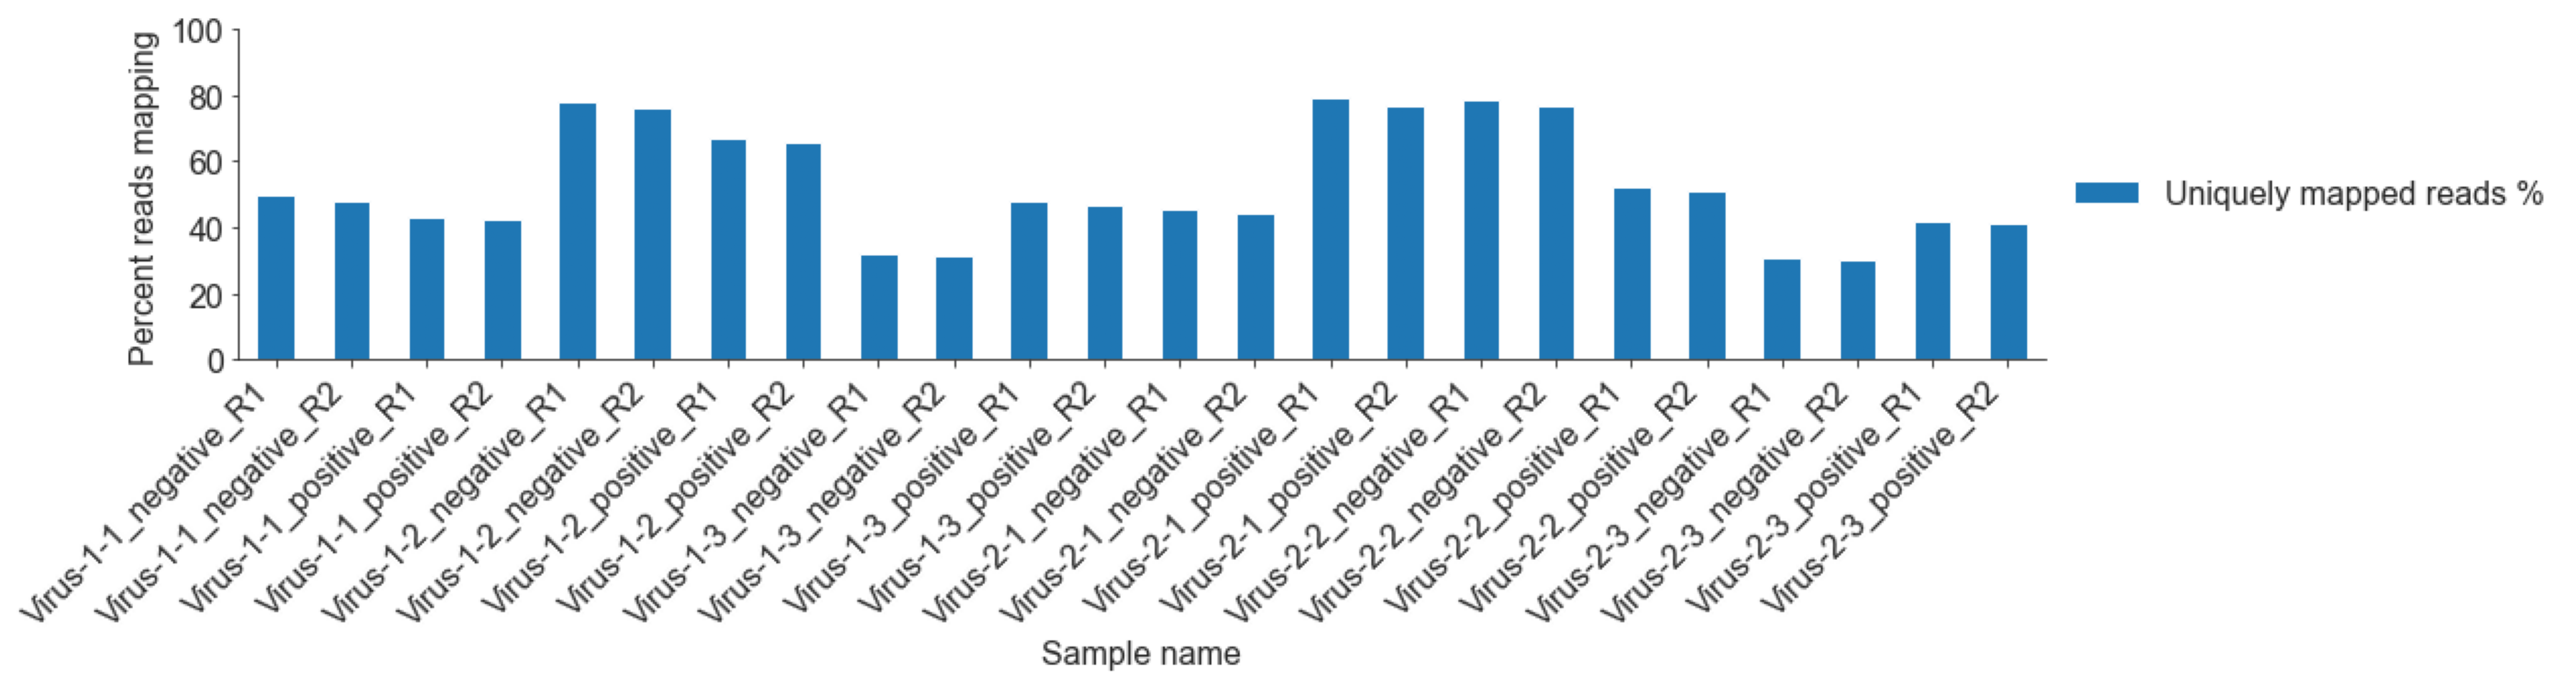

In [18]:


figsDisplay = []
reads = ['R1', 'R2']

data = []
for index, row in unique.iterrows():
    for read in reads:
        sampleName = 'Virus-' + \
               str(row.biological_replicate) + '-' + \
               str(row.technical_replicate) + '_' + \
               row.experimental_condition
        filename = resultsDir + '/STARrealign/' + sampleName + '_vRNA_' + read + '_Log.final.out'
        sampleName = sampleName + '_' + read
        data += [fastQHandling.STARreport(filename,sampleName)]

data = pd.concat(data)
data.loc[:,['Uniquely mapped reads %','Sample name']].set_index('Sample name').plot.bar(stacked=True,figsize=(16,3), fontsize=16)
sns.despine()
plt.legend( loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.xticks(rotation=45,horizontalalignment="right")
plt.ylabel('Percent reads mapping', fontsize=16)
plt.ylim(0,100)
plt.savefig(resultsDir + '/STARrealign/alignment.pdf', format='pdf', bbox_inches = "tight")
#png for showing here
plt.savefig(resultsDir + '/STARrealign/alignment.png', format='png', bbox_inches = "tight")
plt.close()
figsDisplay += [resultsDir + '/STARrealign/alignment.png']
width = 64 * len(figsDisplay)
g = plt.figure(1, (width, 32))
spec = g.add_gridspec(ncols= len(figsDisplay),nrows=1)
for column, fig in enumerate(figsDisplay):
    ax = g.add_subplot(spec[0,column])
    img=mpimg.imread(fig)
    ax.imshow(img)
    ax.axis('off')



Combine all bamfiles and correct flags.

In [19]:
if not os.path.isdir(resultsDir + '/finalAlign/'):
    os.mkdir(resultsDir + '/finalAlign/')
for index, row in unique.iterrows():
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition 
    outbase = resultsDir + '/finalAlign/' + sampleName
    firstAlignBase = resultsDir + '/STARalign/' + sampleName
    secondAlignBase  = resultsDir + '/STARrealign/' + sampleName
    b1_1 = firstAlignBase + '__R1_Aligned.out.bam'
    b1_2 = firstAlignBase + '__R2_Aligned.out.bam'
    b2_1 = secondAlignBase + '_vRNA_R1_Aligned.out.bam'
    b2_2 = secondAlignBase + '_vRNA_R2_Aligned.out.bam'
    tempBam = outbase + '_temp.bam'
    finBam = outbase + '.bam'
    possortBam = outbase + '_position.bam'
    extraCores = numProcessors - 1
    cap = !samtools merge -@ $extraCores $finBam $b1_1 $b1_2 $b2_1 $b2_2
    cap = !samtools sort -n -@ $extraCores -o $tempBam $finBam
    cap = !samtools fixmate -p -@ $extraCores $tempBam $finBam
    cap = !rm -f $tempBam
    cap = !samtools sort -@ $extraCores -o $possortBam $finBam
    !samtools index $possortBam

Count fragments mapping to annotated deletions.

In [ ]:

def rawFragMaps(arguments):
    DeletionAnalysis.rawCounts(junctionFile = arguments[0],sortedBamfile=arguments[1], 
                               outDirectory=arguments[2], requiredMapped=3)
popList = []
if not os.path.isdir(resultsDir + '/RawFragmentCounts/'):
    os.mkdir(resultsDir + '/RawFragmentCounts/')
for index, row in unique.iterrows():
    outDirectory = resultsDir + '/RawFragmentCounts/'
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition 
    junctionFile = resultsDir + '/junctionData/Virus-' + str(row.biological_replicate) + '/threshold_intron.tsv'
    bamfile = resultsDir + '/finalAlign/' + sampleName + '.bam'
    popList.append((junctionFile, bamfile, outDirectory))

while len(popList) > 0:
    with Pool(processes = numProcessors) as p:
        output = p.map(rawFragMaps, [popList.pop() for i in range(numProcessors) if len(popList) != 0] )


Total fragments for FPM conversions.

In [ ]:
outputDir = 'Results/totalFragments/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)
def totalFrag(arguments):
    bamfile = arguments[0]
    numbers = []
    for segment in segments:
        command = f"samtools view -f 0x1 -F 0x900 {bamfile} {segment}"
        command += " | awk '{if($9 != 0) {print $0}}' | wc -l"
        process = subprocess.Popen(command, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()
        #using float as should always be an int, this is just a little check for me
        number = (float(stdout.decode('utf-8')))/float(2)
        numbers += [pd.DataFrame({'segment':[segment], "fragments":[number]})]
    pd.concat(numbers).to_csv(arguments[1], sep='\t')
    

popList = []
for index, row in unique.iterrows():
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition 
    bamfile = resultsDir + '/finalAlign/' + sampleName + '_position.bam'
    outfile = outputDir + sampleName + '_totalFragments.tsv'
    popList.append((bamfile, outfile))
    
while len(popList) > 0:
    with Pool(processes = numProcessors) as p:
        output = p.map(totalFrag, [popList.pop() for i in range(numProcessors) if len(popList) != 0] )

Per/position SNP data.

In [ ]:
def rawSeqMaps(arguments):
    DeletionAnalysis.positionalData(sortedBamfile = arguments[0],outfile=arguments[1],
                               qvalCutoff=arguments[2])


popList = []
if not os.path.isdir(resultsDir + '/SNPcounts/'):
    os.mkdir(resultsDir + '/SNPcounts/')
for index, row in unique.iterrows():
    outDirectory = resultsDir + '/SNPcounts/'
    sampleName = 'Virus-' +            str(row.biological_replicate) + '-' +            str(row.technical_replicate) + '_' +            row.experimental_condition
    junctionFile = resultsDir + '/junctionData/Virus-' + str(row.biological_replicate) + '/threshold_intron.tsv'
    bamfile = resultsDir + '/finalAlign/' + sampleName + '.bam'
    outfile = outDirectory + sampleName + '_SNP.tsv'
    popList.append((bamfile, outfile, 30))

while len(popList) > 0:
    with Pool(processes = numProcessors) as p:
        output = p.map(rawSeqMaps, [popList.pop() for i in range(numProcessors) if len(popList) != 0] )

For NS1 specifically, as deletions are rare, convert BLAST junctions that meet requirements to a fragment-mapped value. 

Will remove junctions annotated in final files as well, and take only those curated numbers as there will be partial double-counting otherwise (and under counting if only taking this number). 

In [55]:
def lineMatch(row, inFile):
    name = row.read
    read = !grep $name $inFile
    if read != []:
        elements = read[0].split('\t')
        startpos = int(elements[3])
        mappedLen = int(''.join([character for character in elements[5] if not character.isalpha()]))
        finalPos = startpos + mappedLen - 1
        if (finalPos < row.fivePrime) | (startpos > row.threePrime):
            return True
        else:
            return False
    else:
        return False
    
for index, row in unique.iterrows():
    sampleName = 'Virus-' + str(row.biological_replicate) + '-' + str(row.technical_replicate) + '_' + row.experimental_condition
    inBLAST = resultsDir + '/BLASTresults/' + sampleName + '_NSannotated_junctions.tsv'
    outFile = resultsDir + '/BLASTresults/' + sampleName + '_NScounts.tsv'
    #anything with duplicates automatically is supported
    blastFrame = pd.read_csv(inBLAST, sep='\t', names = ['read', 'segment', 'fivePrime', 'threePrime'])
    dupli = blastFrame[blastFrame.duplicated( keep='first')]
    #now for the remainder, not bothering with parallel processing on this
    nonDupli = blastFrame[~blastFrame.duplicated( keep=False)]
    tempfile = resultsDir + '/finalAlign/temp.sam'
    inBam = resultsDir + '/finalAlign/' + sampleName + '_position.bam'
    #just NS reads, just unpaired, ungapped. If gaps were unpaired, and common with second deletion, should have met other thresholds
    awkarg = "awk \'($9 == \"0\") && ($6 !~ /N|I|D|S/)\'"
    !samtools view $inBam NS_vRNA | $awkarg > $tempfile
    nonDupli = nonDupli[nonDupli.apply(lambda row: lineMatch(row, tempfile), axis =1)]
    final = pd.concat([dupli, nonDupli]).groupby(['segment','fivePrime','threePrime']).count().reset_index().rename(columns={'read':'counts'})
    final.to_csv(outFile, sep = '\t')
    !rm -f $tempFile

# Graphing of Data

Lets just look at per/base error/mutation rate for areas overlapping NS1, NEP, and both

In [2]:
#load in data, annotate
data = []
for file in glob.glob('Results/SNPcounts/*.tsv'):
    frame = pd.read_csv(file, sep='\t')
    virusName = os.path.basename(file).split('_')[0]
    interferonState = os.path.basename(file).split('_')[1]
    techRep = virusName.split('-')[2]
    bioRep = virusName.split('-')[1]
    frame['biologicalReplicate'] = bioRep
    frame['technicalReplicate'] = techRep
    frame['interferonState'] = interferonState
    data += [frame]
data = pd.concat(data)
data['majorityVariant'] = data[['A','G','C','T']].idxmax(axis=1)
data['totalDepth'] = data[['A','G','C','T']].sum(axis=1)

def minorityVariant(row):
    column = row.majorityVariant
    if row.totalDepth != 0:
        return  1 - (row[column]/row.totalDepth)
    else:
        return 0

data['minorityFreq'] = data.apply(lambda row: minorityVariant(row), axis=1)

data = data.loc[data.segment == 'NS_vRNA',]
data['inactivate'] = 'ignore'


data.loc[(data.position >= 27) & (data.position <= 864), 'inactivate'] = 'both'
data.loc[(data.position >= 363) & (data.position <= 834), 'inactivate'] = 'NS1'
data.loc[(data.position >= 27) & (data.position <= 171), 'inactivate'] = 'NEP'


now graph

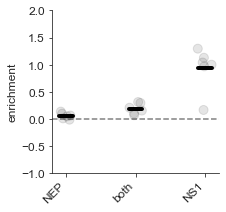

In [7]:
plot = data[data.inactivate != 'ignore'].groupby(['inactivate', 'interferonState','technicalReplicate','biologicalReplicate']).mean().reset_index()



plot = plot.pivot_table(index=['technicalReplicate', 'biologicalReplicate', 'inactivate'], values='minorityFreq', columns = ['interferonState']).reset_index()


plot['enrichment'] = np.log2(plot.positive/plot.negative)

fig, ax = plt.subplots(figsize= (3,3))
order = ['NEP','both','NS1']
sns.stripplot(x='inactivate', y='enrichment', data=plot,  edgecolor='black', order = order,
            jitter=True, dodge=True, linewidth=1, s=9, palette=['0'], alpha = 0.1, ax=ax)

sns.despine()
plt.xlabel('')
plt.ylim(-1,2)
a =plt.xticks(rotation=45, ha='right')


plt.axhline(y=0, color = 'k',ls = '--', alpha =0.5)

#stats!
pvals = []
corresponding = []
for position, inactivate, in enumerate(order):
    for second, secondInactivate in enumerate(order[position+1:]):
        tstat, pval = stats.ttest_rel(plot[plot.inactivate == inactivate].enrichment, plot[plot.inactivate == secondInactivate].enrichment )
        pvals += [pval]
        corresponding += [(position, second + position + 1)]
pvals = retain = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
for position, val in enumerate(pvals):
    y = plot[plot.inactivate == order[position]].enrichment.mean()
    plt.plot([position-0.1, position+0.1], [y, y], lw=4, c='k', zorder=8)
plt.savefig('Figures/meanSNP.pdf')

Run an anova, if p<0.05, use Tukey's post-hoc test to compare between groups. Draw in for figure later. Using code is too messy and it is easiest just to draw, but do want to record values in notebook.

In [6]:
stat, pval = scipy.stats.f_oneway(plot[plot.inactivate == 'NEP'].enrichment, plot[plot.inactivate == 'NS1'].enrichment, plot[plot.inactivate == 'both'].enrichment)
if pval < 0.05:
    tukey = pairwise_tukeyhsd(endog=plot['enrichment'],
                              groups=plot['inactivate'],
                              alpha=0.05)
    print(tukey)
else:
    print('No significant difference detected by ANOVA at a pvalue of 0.05')

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   NEP    NS1   0.8745  0.001  0.5202  1.2288   True
   NEP   both   0.1328 0.5999 -0.2215  0.4871  False
   NS1   both  -0.7417  0.001  -1.096 -0.3874   True
----------------------------------------------------


/Users/alistair/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


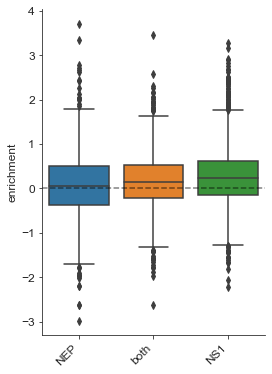

In [17]:
plot = data[data.inactivate != 'ignore'].groupby(['inactivate', 'interferonState','technicalReplicate','biologicalReplicate','position']).mean().reset_index()



plot = plot.pivot_table(index=['technicalReplicate', 'biologicalReplicate', 'inactivate', 'position'], values='minorityFreq', columns = ['interferonState']).reset_index()


plot['enrichment'] = np.log2(plot.positive/plot.negative)
plot = plot[(plot.negative != 0) & (plot.positive !=0)]
fig, ax = plt.subplots(figsize= (4,6))
order = ['NEP', 'both', 'NS1']
sns.boxplot(x='inactivate', y='enrichment', data=plot,   order = order, ax=ax, sho)

sns.despine()
plt.xlabel('')
a =plt.xticks(rotation=45, ha='right')


plt.axhline(y=0, color = 'k',ls = '--', alpha =0.5)


plt.savefig('Figures/allPosSNP.pdf')


ANOVA, tukey if appropriate

In [10]:
stat, pval = scipy.stats.f_oneway(plot[plot.inactivate == 'NEP'].enrichment, plot[plot.inactivate == 'NS1'].enrichment, plot[plot.inactivate == 'both'].enrichment)
if pval < 0.05:
    tukey = pairwise_tukeyhsd(endog=plot['enrichment'],
                              groups=plot['inactivate'],
                              alpha=0.05)
    print(tukey)
else:
    print('No significant difference detected by ANOVA at a pvalue of 0.05')

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   NEP    NS1   0.2137 0.001  0.1536  0.2739   True
   NEP   both    0.106 0.001  0.0384  0.1736   True
   NS1   both  -0.1077 0.001 -0.1592 -0.0562   True
---------------------------------------------------


What about deletions? First, lets load in data.

In [3]:
data = []
for file in glob.glob('Results/RawFragmentCounts/*Raw.tsv'):
    IFNstate = file.split('_')[-2]
    techRep = file.split('_')[-3].split('-')[-1]
    bioRep = file.split('_')[-3].split('-')[-2]
    currFrame = pd.read_csv(file, sep='\t')
    currFrame['biological_replicate'] = bioRep
    currFrame['technical_replicate'] = techRep
    currFrame['interferonState'] = IFNstate
    data += [currFrame]
data = pd.concat(data)

Does the distribution both of total and unique make sense?

/Users/alistair/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  import sys


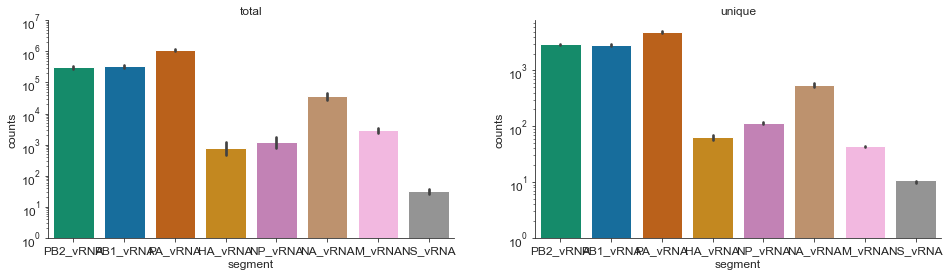

In [8]:
fig,axes = plt.subplots(1,2, figsize=(16,4))

total = data.groupby(['segment', 'technical_replicate', 'biological_replicate', 'interferonState']).sum().reset_index()
sns.barplot(data= total, x='segment', y='counts' ,order= segments, palette=fluColors, ax = axes[0], bottom=1)
sns.despine()
axes[0].set_yscale('log')
axes[0].set_ylim(0,10**7)
axes[0].set_title('total')
unique = data.groupby(['segment', 'technical_replicate', 'biological_replicate', 'interferonState']).count().reset_index()
sns.barplot(data= unique, x='segment', y='counts' ,order= segments, palette=fluColors, ax = axes[1], bottom=1)
sns.despine()
axes[1].set_yscale('log')
axes[1].set_title('unique')
plt.savefig('Figures/totalDeletions.pdf')

In [4]:
data

segment  fivePrime  threePrime  counts biological_replicate  \
0       PA_vRNA        233        1998       3                    2   
1      PB1_vRNA        666        1701      78                    2   
2       PA_vRNA        166        1809      66                    2   
3      PB2_vRNA        541        1890     577                    2   
4       PA_vRNA        221        2095       4                    2   
...         ...        ...         ...     ...                  ...   
12524   PA_vRNA        409        1827       8                    1   
12525  PB2_vRNA        185         269      37                    1   
12526  PB1_vRNA        185        2090     988                    1   
12527   PA_vRNA        413        2165     319                    1   
12528  PB2_vRNA        510        2077       3                    1   

      technical_replicate interferonState  
0                       3        negative  
1                       3        negative  
2                       3        negative  
3                       3        negative  
4                       3        negative  
...                   ...             ...  
12524                   2        positive  
12525                   2        positive  
12526                   2        positive  
12527                   2        positive  
12528                   2        positive  

[137754 rows x 7 columns]


combine datasets, account for duplicates, then correct for total depth

In [5]:
newData = []
for file in glob.glob('Results/BLASTresults/*NScounts.tsv'):
    IFNstate = file.split('_')[-2]
    techRep = file.split('_')[-3].split('-')[-1]
    bioRep = file.split('_')[-3].split('-')[-2]
    currFrame = pd.read_csv(file, sep='\t')
    currFrame['biological_replicate'] = bioRep
    currFrame['technical_replicate'] = techRep
    currFrame['interferonState'] = IFNstate
    newData += [currFrame[['segment', 'fivePrime', 'threePrime', 'biological_replicate', 'technical_replicate', 'interferonState', 'counts']]]
data = pd.concat([data] + newData)
data = data[data.segment == 'NS_vRNA']
data = data[data['counts'] > 0]
data = data[~data.duplicated( keep='first', subset=['segment', 'fivePrime', 'threePrime', 'biological_replicate', 'technical_replicate', 'interferonState'])]

totals = []
for file in glob.glob('Results/totalFragments/*.tsv'):
    IFNstate = file.split('_')[-2]
    techRep = file.split('_')[-3].split('-')[-1]
    bioRep = file.split('_')[-3].split('-')[-2]
    currFrame = pd.read_csv(file, sep='\t')
    currFrame['biological_replicate'] = bioRep
    currFrame['technical_replicate'] = techRep
    currFrame['interferonState'] = IFNstate
    totals += [currFrame]
totals = pd.concat(totals)[['segment','biological_replicate', 'technical_replicate', 'fragments', 'interferonState']]
data = data.merge(totals)

data['FPM'] = data['counts']/data['fragments'] * 10**6

Do deletions in NS generally associate with interferon? Check across both biological replicates.

pvalue of 0.03101170218405153


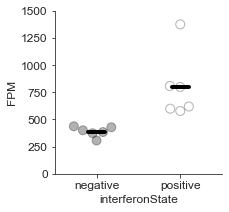

In [22]:
graph = data.groupby(['biological_replicate', 'technical_replicate', 'interferonState']).sum().reset_index()

fig,ax = plt.subplots(figsize=(3,3))
order = ['negative', 'positive']

sns.swarmplot(y='FPM', x='interferonState', data=graph,
               palette = ['0', '1'], edgecolor='0', dodge=True, linewidth=1, s=9,  ax=ax, alpha=0.3, clip_on=False, order = order)

ax.set_ylim(0,1500)
sns.despine()
tstat, pval = stats.ttest_rel(graph[graph.interferonState == 'positive'].FPM, graph[graph.interferonState == 'negative'].FPM )
print('pvalue of ' + str(pval))

for position, val in enumerate(order):
    y = graph[graph.interferonState == order[position]].FPM.mean()
    plt.plot([position-0.1, position+0.1], [y, y], lw=4, c='k', zorder=8)
plt.savefig('Figures/NSdeletionEnrichment.pdf')

Annotate

In [23]:
data['inactivate'] = 'ignore'
data.loc[(data.fivePrime >= 27) &  (data.threePrime <= 864), 'inactivate'] = 'both'
data.loc[(data.fivePrime >= 27) & (data.threePrime <= 171), 'inactivate'] = 'NEP'
data.loc[(data.fivePrime >= 363) & (data.threePrime <= 834), 'inactivate'] = 'NS1'
data = data[data.inactivate != 'ignore']

NEP are rare enough to be absent from a dataset. Just compare both to NS1 alone.

pvalue of 0.010014592411056702


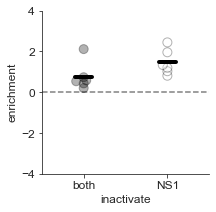

In [24]:
graph = data.groupby(['inactivate', 'technical_replicate', 'biological_replicate', 'interferonState']).sum().reset_index()
graph = graph.pivot_table(index=['inactivate', 'technical_replicate', 'biological_replicate'], columns = ['interferonState'], values='FPM').reset_index()
graph = graph[graph.inactivate.isin(['both', 'NS1'])]
graph['enrichment'] = np.log2(graph.positive/graph.negative)
fig,ax = plt.subplots(figsize=(3,3))
order = ['both', 'NS1']

sns.swarmplot(y='enrichment', x='inactivate', data=graph,
               palette = ['0', '1'], edgecolor='0', dodge=True, linewidth=1, s=9,  ax=ax, alpha=0.3, clip_on=False, order = order)

sns.despine()
ax.set_ylim(-4,4)
ax.axhline(y=0, color = 'k',ls = '--', alpha =0.5)
tstat, pval = stats.ttest_rel(graph[graph.inactivate == 'both'].enrichment, graph[graph.inactivate == 'NS1'].enrichment )
print('pvalue of ' + str(pval))
for position, val in enumerate(order):
    y = graph[graph.inactivate == order[position]].enrichment.mean()
    plt.plot([position-0.1, position+0.1], [y, y], lw=4, c='k', zorder=8)
plt.savefig('Figures/NSspecificdeletionenrichment.pdf')